In [3]:
import pandas as pd
import numpy as np
df = pd.read_excel("/content/thyao.csv")
df.head()
yeni_df = df[['Özkaynaklar','Dönem Net Kar/Zararı']]
yeni_df

Buradaki amaç verimizi çoğaltmaktır. İki bilonço arasında yaklaşık 62 iş günü olduğu için her özelliğimiz arasına lineer bir şekilde iki değer arasında 62 tane artan veya azalan veriler üretmektir.

In [ ]:
x = {}
empty_df = pd.DataFrame(columns=yeni_df.columns)
first_row = yeni_df.iloc[[0]]
empty_df = empty_df.append(first_row, ignore_index=True)

for i in range(yeni_df.shape[0]-1):
  for j in range(yeni_df.shape[1]):
    array = np.linspace(yeni_df.iloc[i,j], yeni_df.iloc[i+1,j], 64)
    liste = array.tolist()
    x[yeni_df.columns[j]] = liste
  a = pd.DataFrame(x)
  empty_df = pd.concat([empty_df,a.iloc[1:]]).reset_index(drop=True)
  x = {}
df = empty_df

fiyat veri setindeki veri seti 15 eleman fazla olduğu için veri setimizden 15 satırı rastgele çıkarıyoruz.

In [ ]:
silinecek_indeksler = np.random.randint(200, 3000, size=15)

# Seçilen satırları kaldıralım
df_son = df.drop(df.index[silinecek_indeksler])
df_son.reset_index(drop=True, inplace=True)

df_son veri setimiz ile fiyat veri setimizi excelden kopya yapıştır ile birleştirildi. son_thyao2 iki olarak kaydedildi

In [ ]:
df = pd.read_csv("/content/son_thyao2.csv")
df


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error

In [ ]:
train_dataset=df[:2770]
test_dataset=df[2770:]

scaler = MinMaxScaler(feature_range=(-1,1))
scaler2 = MinMaxScaler(feature_range=(-1,1))
train_scaled = scaler.fit_transform(train_dataset)
test_scaled  =scaler2.fit_transform(test_dataset)
test_scaled

In [41]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,-1])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(train_scaled,30)
testX,testY=createXY(test_scaled,30)

In [ ]:
print("trainX Shape-- ",trainY)

In [ ]:
from tensorflow.keras.optimizers import Adam
def build_model():
    regressor = Sequential()

    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (30,5)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return regressor
model = build_model()

# Modeli eğit
history = model.fit(trainX , trainY, epochs = 100, validation_split=0.1, batch_size = 64, verbose=1)

In [ ]:
prediction= model.predict(testX)
print("prediction\n", prediction)

In [ ]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)
pred=scaler2.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,-1]
original_copies_array = np.repeat(testY,5, axis=-1)
original=scaler2.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,-1]
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

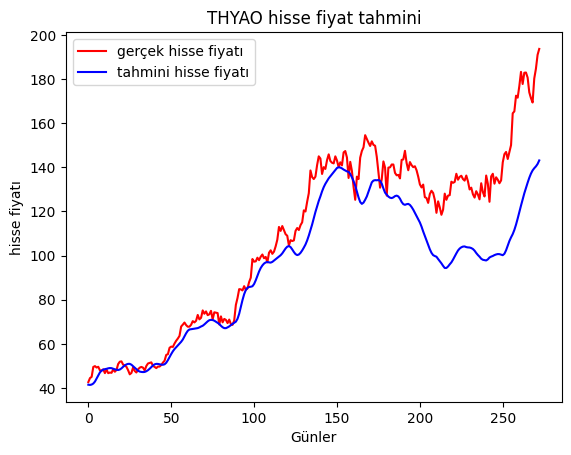

In [50]:
plt.plot(original, color = 'red', label = 'gerçek hisse fiyatı')
plt.plot(pred, color = 'blue', label = 'tahmini hisse fiyatı')
plt.title('THYAO hisse fiyat tahmini')
plt.xlabel('Günler')
plt.ylabel('hisse fiyatı')
plt.legend()
plt.show()
